In [3]:
import os
import scipy.io 
import numpy as np

In [ ]:
# Converting .mat files to .npy files
mat_folder = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\DataCube\DataCube"  
output_folder = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\DataCube\DataCube_npz" 

os.makedirs(output_folder, exist_ok=True)

mat_files = [file for file in os.listdir(mat_folder) if file.endswith(".mat")]



for mat_file in mat_files:
    mat_path = os.path.join(mat_folder, mat_file)
    data = scipy.io.loadmat(mat_path)
    indices = data.get("indices")
    spectra = data.get("spectra")  
    wavenumbers = data.get("wavenumbers")  

    if spectra is None or wavenumbers is None or indices is None:
        print(f"Skipping {mat_file}: Missing 'spectra','wavenumbers', or indices")
        continue

    # Save as .npz files
    npz_path = os.path.join(output_folder, mat_file.replace(".mat", ".npz"))
    np.savez_compressed(npz_path, spectra=spectra, wavenumbers=wavenumbers, indices=indices)
    npz_name = os.path.basename(npz_path)
    
    print(f"Converted {mat_file} to {npz_name}")

print("Conversion done")


    


<!-- # Quality control: Remove low intensity spectra, PCA (80), removing paraffin wax regions -->

<!-- ## Create training data - saved as training.npz -->

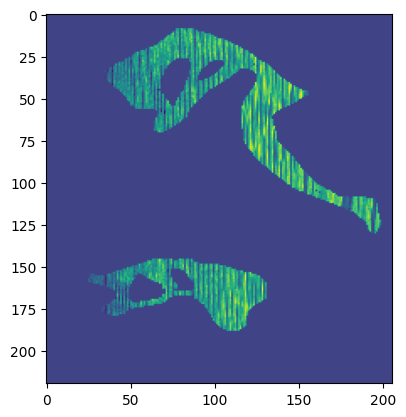

In [ ]:
def overlay_extracted_pixels(img, extracted_rows, extracted_cols):
    overlay_img = img.copy()
    overlay_img = overlay_img[:,:,:3]
    for r, c in zip(extracted_rows, extracted_cols):
        overlay_img[r, c] = (255, 192, 203)  # pink overlay for detected pixels

    # Display overlay image
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_img)
    plt.title(f"Overlay of Detected Spectra for {core_name}")
    plt.axis("off")
    plt.show()

# Find annotated pixels
def find_colour_positions(img,colour):
    return set(zip(*np.where(
        (img[:, :, 0] == colour[0]) & 
        (img[:, :, 1] == colour[1]) &
        (img[:, :, 2] == colour[2])
    )))

# Define file locations
data_location = r"C:\Users\user\Desktop\HSI-project\DataCube_npz"
annotation_location = r"C:\Users\user\Desktop\HSI-project\overlay"

core_names = [
    "A12","C10", "C16", "C5", "C8",
    "D5", "D7", "D8", "D9", "E7", "E8", "F5", "F7", "F8",
    "G6", "H7", "H10", "H9", "I3", "I5", "A14", "I7", "B9", "I10",
    "K1", "K10", "K6", "K9", "B11", "L10", "L2", "L3",
    "M1", "M3", "M4", "M6", "M9", "M10", "M11", "M13"
]

annotation_colours = {
    "red": (255, 0, 0),
    "green": (103, 193, 66),
    "orange":(243,143,53),
    "purple":(165,55,156)
}

all_spectra = []
count_spectra = []
Y = []
    
# Process each core
for core_name in core_names:
    mat_path = os.path.join(data_location, core_name + ".npz")
    img_path = os.path.join(annotation_location, core_name + ".png")

    data = np.load(mat_path)

    spectra = data["spectra"]
    wavenumbers = data["wavenumbers"]
    indices = data["indices"].flatten()

    annotated_img = np.array(Image.open(img_path))
    
    # Fix dimensions (Swapped to match MATLAB)
    ypixels, xpixels = annotated_img.shape[:2]

    # Convert indices to (row, col) positions
    rows = indices % ypixels  
    cols = indices // ypixels

    # Convert to NumPy array for consistency
    pixel_positions = np.column_stack((rows, cols))  
    # print(len(pixel_positions))

    red_positions = find_colour_positions(annotated_img, annotation_colours["red"])
    purple_positions = find_colour_positions(annotated_img, annotation_colours["purple"])
    green_positions = find_colour_positions(annotated_img, annotation_colours["green"])
    orange_positions = find_colour_positions(annotated_img, annotation_colours["orange"])
    
    core_spectra = []
    extracted_rows = []
    extracted_cols = []
            
    for i in range(len(pixel_positions)):
        row, col = pixel_positions[i]
        if i >= spectra.shape[0]:  # Prevent index out of bounds
            continue  

        if (row, col) in red_positions or (row, col) in purple_positions:
            core_spectra.append(spectra[i])
            # extracted_rows.append(row)
            # extracted_cols.append(col)
        elif (row, col) in green_positions or (row, col) in orange_positions:
            core_spectra.append(spectra[i])
            # extracted_rows.append(row)
            # extracted_cols.append(col)
            

    # Convert to numpy array
    core_spectra = np.array(core_spectra)
    # pca
    clean_spectra = denoise_pca(core_spectra)
    all_spectra.append(clean_spectra)
    
    count_spectra.append((core_name, clean_spectra.shape[0]))
 
    # Overlay detected pixels
    # overlay_extracted_pixels(annotated_img, extracted_rows, extracted_cols)
# Convert list to NumPy arrays
all_spectra = [np.array(core, dtype=np.float32) for core in all_spectra]

# print(all_spectra)
# Sort and plot core sizes
count_spectra.sort(key=lambda x: x[1])
core_names_sorted, pixel_counts_sorted = zip(*count_spectra)

plt.figure(figsize=(12, 6))
plt.bar(core_names_sorted, pixel_counts_sorted, colour="skyblue")

min_annotated_pixels = pixel_counts_sorted[0]
# Highlight the core with the minimum pixel count
min_core_index = pixel_counts_sorted.index(min_annotated_pixels)
plt.bar(core_names_sorted[min_core_index], pixel_counts_sorted[min_core_index], colour="red", label="Min Core")

# Add labels and title
plt.xlabel("Core ID")
plt.ylabel("Number of Annotated Pixels")
plt.title("Number of Annotated Pixels per Core")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Minimum annotated pixels per core: {pixel_counts_sorted[0]}")

## Getting X and Y

In [5]:
# Converting .mat files to .npy files
training_path = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\processed-data" 

os.makedirs(training_path, exist_ok=True)

# Min_all_spectra is taking the minimum annotated pixels from all cores at random
min_all_spectra = []

for core in all_spectra:
    min_all_spectra.append(core[np.random.choice(core.shape[0],min_annotated_pixels, replace=False)])

min_all_spectra = np.array(min_all_spectra,dtype=np.float32) # potential change: reshape min_all_spectra to 2d from 3d ( N ,1478)

wavenumbers = wavenumbers.flatten()
X = preprocess(min_all_spectra, wavenumbers)
print("X shape",X.shape) # want this to be (40, something, 558)

Y = []
csv_directory = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\BR20832.csv"
df = pd.read_csv(csv_directory, usecols=["position", "type"])

df["type"] = df["type"].str.lower().map({"malignant": 1, "normal": 0, "nat": 0})
label_dict = df.set_index("position")["type"].to_dict()

for core in core_names:
   Y.append(label_dict.get(core))
# print(Y)
print("Y shape",len(Y))


# Save as .npz files
training_data_path = os.path.join(training_path, 'training.npz')
np.savez_compressed(training_data_path, X=X, Y=Y)

print("Saved to training.npz")


X shape (40,)
Y shape 40
Saved to training.npz


## Same for test set

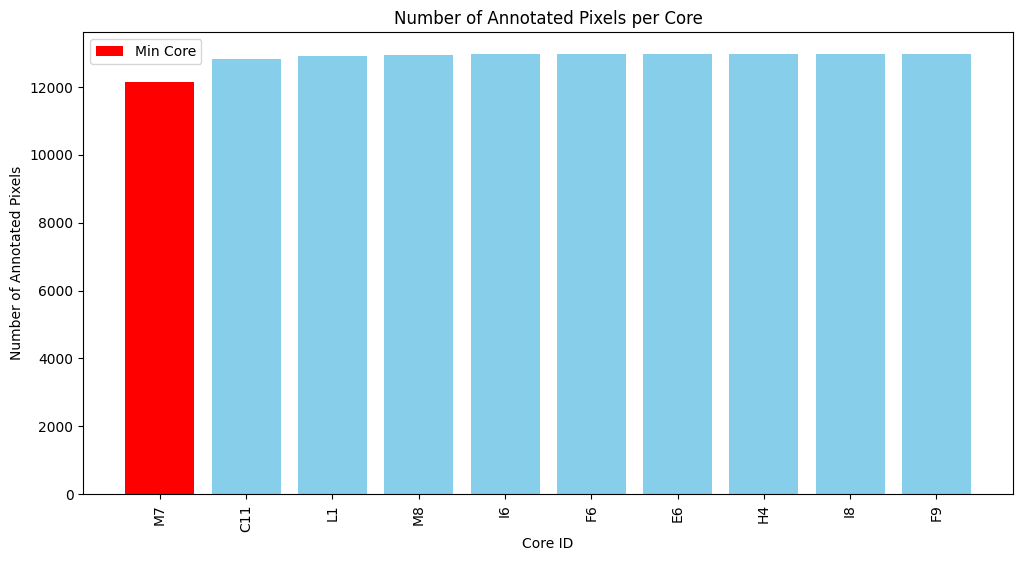

Minimum annotated pixels per core: 12155
X shape (10,)
Y shape 10
Saved to testing.npz


In [ ]:

core_names = [
    'L1','I8','H4','E6','C11','F6','F9','I6','M7','M8'
]

annotation_colourrs = {
    "red": (255, 0, 0),
    "green": (103, 193, 66),
    "orange":(243,143,53),
    "purple":(165,55,156)
}

all_spectra = []
count_spectra = []
Y = []
    
# Process each core
for core_name in core_names:
    mat_path = os.path.join(data_location, core_name + ".npz")
    img_path = os.path.join(annotation_location, core_name + ".png")

    data = np.load(mat_path)

    spectra = data["spectra"]
    wavenumbers = data["wavenumbers"]
    indices = data["indices"].flatten()

    annotated_img = Image.open(img_path)
    annotated_img = np.array(annotated_img)
    # annotated_img = cv2.cvtcolour(cv2.imread(img_path), cv2.colour_BGR2RGB) - faster because don't need to convert each from bgr2rgb
    # print(annotated_img.shape)
    
    # Fix dimensions (Swapped to match MATLAB)
    ypixels, xpixels = annotated_img.shape[:2]
    # ypixels, xpixels = annotated_img.shape[0], annotated_img.shape[1]

    # Convert indices to (row, col) positions
    rows = indices % ypixels  
    cols = indices // ypixels

    # Convert to NumPy array for consistency
    pixel_positions = np.column_stack((rows, cols))  
    # print(len(pixel_positions))

    core_spectra = []
    extracted_rows = []
    extracted_cols = []
            
    for i in range(len(pixel_positions)):
        row, col = pixel_positions[i]
        if i >= spectra.shape[0]:  # Prevent index out of bounds
            continue  

        if (row, col) in red_positions or (row, col) in purple_positions:
            core_spectra.append(spectra[i])
            extracted_rows.append(row)
            extracted_cols.append(col)
        elif (row, col) in green_positions or (row, col) in orange_positions:
            core_spectra.append(spectra[i])
            extracted_rows.append(row)
            extracted_cols.append(col)
            

    # Convert to numpy array
    core_spectra = np.array(core_spectra)
    # pca
    clean_spectra = pca(core_spectra)
    all_spectra.append(clean_spectra)
    
    count_spectra.append((core_name, clean_spectra.shape[0]))
 
    # Overlay detected pixels
    # overlay_extracted_pixels(annotated_img, extracted_rows, extracted_cols)
# Convert list to NumPy arrays
all_spectra = [np.array(core, dtype=np.float32) for core in all_spectra]

# print(all_spectra)
# Sort and plot core sizes
count_spectra.sort(key=lambda x: x[1])
core_names_sorted, pixel_counts_sorted = zip(*count_spectra)

plt.figure(figsize=(12, 6))
plt.bar(core_names_sorted, pixel_counts_sorted, colour="skyblue")

min_annotated_pixels = pixel_counts_sorted[0]
# Highlight the core with the minimum pixel count
min_core_index = pixel_counts_sorted.index(min_annotated_pixels)
plt.bar(core_names_sorted[min_core_index], pixel_counts_sorted[min_core_index], colour="red", label="Min Core")

# Add labels and title
plt.xlabel("Core ID")
plt.ylabel("Number of Annotated Pixels")
plt.title("Number of Annotated Pixels per Core")
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Minimum annotated pixels per core: {pixel_counts_sorted[0]}")

# Converting .mat files to .npy files
testing_path = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\processed-data" 

os.makedirs(testing_path, exist_ok=True)

# Min_all_spectra is taking the minimum annotated pixels from all cores at random
min_all_spectra = []

for core in all_spectra:
    min_all_spectra.append(core[np.random.choice(core.shape[0],min_annotated_pixels, replace=False)])

min_all_spectra = np.array(min_all_spectra,dtype=np.float32) # potential change: reshape min_all_spectra to 2d from 3d ( N ,1478)

wavenumbers = wavenumbers.flatten()
X = preprocess(min_all_spectra, wavenumbers)
print("X shape",X.shape) # want this to be (40, something, 558)

Y = []
df = pd.read_csv(csv_directory, usecols=["position", "type"])

df["type"] = df["type"].str.lower().map({"malignant": 1, "normal": 0, "nat": 0})
label_dict = df.set_index("position")["type"].to_dict()

for core in core_names:
   Y.append(label_dict.get(core))
# print(Y)
print("Y shape",len(Y))


# Save as .npz files
testing_data_path = os.path.join(testing_path, 'testing.npz')
np.savez_compressed(testing_data_path, X=X, Y=Y)

print("Saved to testing.npz")


In [11]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


GPU Available: True
GPU Name: NVIDIA GeForce MX250


In [8]:
training_path = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\processed-data\training.npz" 
testing_path  = r"C:\Users\Edmund Chia\Desktop\HSI-cancer-fyp\processed-data\testing.npz" 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

data = np.load(training_path, allow_pickle=True)
X = data["X"]
Y = data["Y"]

# print(X)
# print(Y)

# Define a 1D CNN for Spectral Data
class SpectralCNN(nn.Module):
    def __init__(self, input_dim=558, num_classes=2):
        super(SpectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Pooling over spectral dimension
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling
        x = self.fc(x)
        return x

class SpectraDataset(Dataset):
    def __init__(self, X, Y):
        self.data = []
        self.labels = []
        
        for i, spectra in enumerate(X):
            num_pixels = spectra.shape[0]
            self.data.append(torch.tensor(spectra, dtype=torch.float32))  # Store spectra
            self.labels.extend([Y[i]] * num_pixels)  # Repeat label for each pixel

        self.data = torch.cat(self.data, dim=0)  # Stack all spectra
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension


# Convert X, Y to Dataset
dataset = SpectraDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectralCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")




Epoch 1/20, Loss: 0.4019
Epoch 2/20, Loss: 0.2389
Epoch 3/20, Loss: 0.1829
Epoch 4/20, Loss: 0.1549
Epoch 5/20, Loss: 0.1395
Epoch 6/20, Loss: 0.1208
Epoch 7/20, Loss: 0.1186
Epoch 8/20, Loss: 0.1071
Epoch 9/20, Loss: 0.1023
Epoch 10/20, Loss: 0.0924
Epoch 11/20, Loss: 0.0882
Epoch 12/20, Loss: 0.0827
Epoch 13/20, Loss: 0.0848
Epoch 14/20, Loss: 0.0696
Epoch 15/20, Loss: 0.0796
Epoch 16/20, Loss: 0.0652
Epoch 17/20, Loss: 0.0600
Epoch 18/20, Loss: 0.0615
Epoch 19/20, Loss: 0.0549
Epoch 20/20, Loss: 0.0564


In [1]:
def preprocess(spectra_list, wavenumbers):

    processed_spectra = []

    for spectra in spectra_list:  # Process each core separately
        if spectra.shape[0] == 0:  # Skip empty cores
            processed_spectra.append(np.array([]))
            continue

        # **1. Quality Filtering: Amide I Band intensity between 0.1 and 2**
        amide_band_indices = np.where((wavenumbers >= 1600) & (wavenumbers <= 1700))[0]
        amide_spectra = np.max(spectra[:, amide_band_indices], axis=1)  # Max absorbance in Amide I region
        valid_spectra = (amide_spectra >= 0.1) & (amide_spectra <= 2)
        good_spectra = spectra[valid_spectra]

        if good_spectra.shape[0] == 0:  # Skip if no valid spectra
            processed_spectra.append(np.array([]))
            continue

        # **2. Removing paraffin wax regions**
        valid_wavenumbers = (
            ((wavenumbers >= 1000) & (wavenumbers <= 1319)) | 
            ((wavenumbers >= 1481) & (wavenumbers <= 1769)) |
            ((wavenumbers >= 2986) & (wavenumbers <= 3569))
        )
        filtered_spectra = good_spectra[:, valid_wavenumbers]
        wavenumbers_filtered = wavenumbers[valid_wavenumbers]

        # **3. Compute First Derivative Using Savitzky-Golay Filter**
        window_size = 19  
        poly_order = 4
        spectra_derivative = savgol_filter(
            filtered_spectra, window_length=window_size, polyorder=poly_order, deriv=1, axis=1
        )

        # **4. Remove Edge Regions Influenced by Derivatization**
        end_region_wavenumbers = (
            ((wavenumbers_filtered >= 1019) & (wavenumbers_filtered <= 1300)) |
            ((wavenumbers_filtered >= 1500) & (wavenumbers_filtered <= 1750)) |
            ((wavenumbers_filtered >= 3005) & (wavenumbers_filtered <= 3550))
        )
        quality_spectra = spectra_derivative[:, end_region_wavenumbers]

        processed_spectra.append(quality_spectra)

    return processed_spectra  # List of NumPy arrays (one per core)
